In [7]:
# img_directory = '/home/ec2-user/img_align_celeba'
# img_directory = '/Users/rwilliams/Desktop/celeba/training'
img_directory = '/home/ec2-user/img_align_celeba'
# img_directory = '/home/ec2-user/autoencoder-vaegan/colbert'
model_save_path = '/home/ec2-user/vaegan-celeba.ckpt'
batch_size = 64
# training_set_size = 3326
training_set_size = 64
img_size = 128
zsize = 128

In [2]:
import sys
sys.path.append('/home/ec2-user/autoencoder-vaegan')

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
from utils import imshow, resize_crop, load_img
%matplotlib inline

In [3]:
# load training data
training = np.array([resize_crop(load_img(i+1, img_directory), (img_size, img_size)) for i in range(training_set_size)])

/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# Build graph

In [8]:
# create models

import tensorflow as tf
from autoencoder import Autoencoder
from discriminator import Discriminator

tf.reset_default_graph()

# input images feed
X = tf.placeholder(tf.float32, [None, img_size, img_size, 3])

# for feeding random draws of z (latent variable)
Z = tf.placeholder(tf.float32, [None, zsize])

# encoder, decoder that will be connected to a discriminator
vae = Autoencoder(img_shape=(img_size, img_size, 3), zsize=zsize)
encoder = vae.encoder(X)
decoder = vae.decoder(encoder)

# a second decoder for decoding samplings of z
decoder_z_obj = Autoencoder(img_shape=(img_size, img_size, 3), zsize=zsize)
decoder_z = decoder_z_obj.decoder(Z, reuse=True)

# discriminator attached to vae output
disc_vae_obj = Discriminator(img_shape=(img_size, img_size, 3))
disc_vae_obj.disc(decoder)
disc_vae_logits = disc_vae_obj.logits

# discriminator attached to X input
# shares weights with other discriminator
disc_x_obj = Discriminator(img_shape=(img_size, img_size, 3))
disc_x_obj.disc(X, reuse=True)
disc_x_logits = disc_x_obj.logits

# discriminator attached to random Zs passed through decoder
# shares weights with other discriminator
disc_z_obj = Discriminator(img_shape=(img_size, img_size, 3))
disc_z_obj.disc(decoder_z, reuse=True)
disc_z_logits = disc_z_obj.logits

# Loss functions and optimizers

In [ ]:
learning_rate = 0.00001

# set up loss functions and training_ops

# latent loss used for training encoder
latent_loss = vae.latent_loss()

# loss that uses decoder to determine similarity between
# actual input images and output images from the vae
similarity_xentropy = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=disc_x_obj.similarity, 
    logits=disc_vae_obj.similarity)
similarity_loss = tf.reduce_sum(similarity_xentropy)

# losses for the discriminator's output. Labes are real: 0, fake: 1.
# cross entropy with 1 labes, since training prob that image is fake
disc_vae_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.ones_like(disc_vae_logits),
    logits=disc_vae_logits))

# cross entropy with 0 labes, since training prob that image is fake
disc_x_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.zeros_like(disc_x_logits),
    logits=disc_x_logits))

# cross entropy with 1 labes, since training prob that image is fake
disc_z_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.ones_like(disc_z_logits),
    logits=disc_z_logits))

# minimize these with optimizer
disc_loss = disc_vae_loss + disc_x_loss + disc_z_loss
encoder_loss = latent_loss + similarity_loss
decoder_loss = similarity_loss - disc_loss

# get weights to train for each of encoder, decoder, etc.
# pass this to optimizer so it only trains w.r.t the network
# we want to train and just uses other parts of the network as is
# (for example use the discriminator to compute a loss during training
# of the encoder, but don't adjust weights of the discriminator)

encoder_vars = [i for i in tf.trainable_variables() if 'encoder' in i.name]
decoder_vars = [i for i in tf.trainable_variables() if 'decoder' in i.name]
disc_vars = [i for i in tf.trainable_variables() if 'discriminator' in i.name]

train_encoder = tf.train.AdamOptimizer(learning_rate=learning_rate) \
    .minimize(encoder_loss, var_list=encoder_vars)
    
train_decoder = tf.train.AdamOptimizer(learning_rate=learning_rate) \
    .minimize(decoder_loss, var_list=decoder_vars)
    
train_disc = tf.train.AdamOptimizer(learning_rate=learning_rate) \
    .minimize(disc_loss, var_list=disc_vars)

saver = tf.train.Saver()

# Init session

In [6]:
config = tf.ConfigProto(device_count = {'GPU': 0})

sess = tf.InteractiveSession(config=config)
# tf.global_variables_initializer().run()
saver.restore(sess, model_save_path)

INFO:tensorflow:Restoring parameters from /home/ec2-user/vaegan-celeba.ckpt


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [256,512] rhs shape= [6400,512]
	 [[Node: save/Assign_128 = Assign[T=DT_FLOAT, _class=["loc:@discriminator/dense/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](discriminator/dense/kernel/Adam, save/RestoreV2_128)]]

Caused by op 'save/Assign_128', defined at:
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-4dbf0df4d99e>", line 52, in <module>
    saver = tf.train.Saver()
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1140, in __init__
    self.build()
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1172, in build
    filename=self._filename)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 688, in build
    restore_sequentially, reshape)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 419, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 155, in restore
    self.op.get_shape().is_fully_defined())
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 274, in assign
    validate_shape=validate_shape)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 43, in assign
    use_locking=use_locking, name=name)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ec2-user/.conda/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [256,512] rhs shape= [6400,512]
	 [[Node: save/Assign_128 = Assign[T=DT_FLOAT, _class=["loc:@discriminator/dense/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](discriminator/dense/kernel/Adam, save/RestoreV2_128)]]


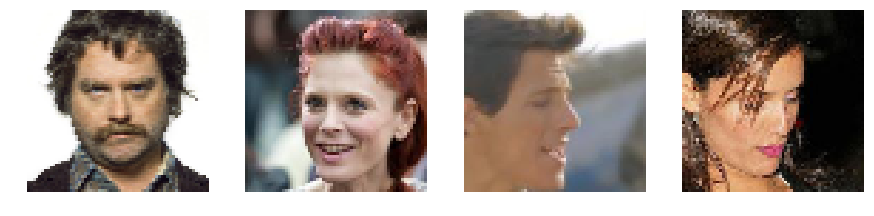

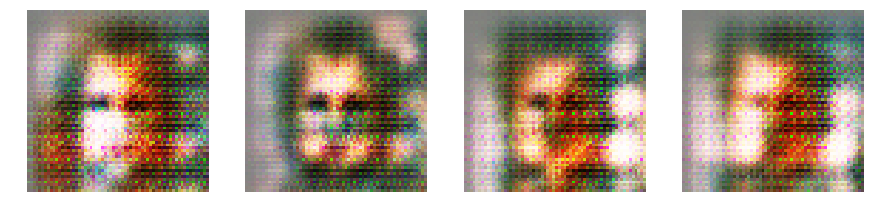

In [23]:
vae_out = decoder.eval(feed_dict={X: training[:4]})
imshow(training[:4])
imshow(vae_out[:4])